# Load Model From Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initialize Paths of Models and Parameters

In [2]:
path= "/content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/"

model_list=["1000","2908","5000","10000"]

# Install and Import Modules

In [3]:
!pip install -q "tensorflow==2.8.*"
!pip install -q "tensorflow-text==2.8.*"

     |████████████████████████████████| 497.9 MB 33 kB/s 
     |████████████████████████████████| 5.8 MB 46.8 MB/s 
     |████████████████████████████████| 462 kB 64.2 MB/s 
     |████████████████████████████████| 1.4 MB 49.6 MB/s 
     |████████████████████████████████| 4.9 MB 4.3 MB/s 


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import pickle
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras import layers , activations , models , preprocessing , utils
from tensorflow.keras.models import load_model
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import tensorflow_text as text

In [5]:
!pip install fasttext
import fasttext.util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 2.2 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3166311 sha256=07a3e1a2d3cc20568c2ef05680c97b57fc7684c957de24c6fc290efede019d83
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


# Download Sentences for Test

In [6]:
!wget http://www.manythings.org/anki/hin-eng.zip -O hin-eng.zip
!unzip hin-eng.zip

--2022-10-16 08:27:24--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131711 (129K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 128.62K   267KB/s    in 0.5s    

2022-10-16 08:27:25 (267 KB/s) - ‘hin-eng.zip’ saved [131711/131711]

Archive:  hin-eng.zip
  inflating: hin.txt                 
  inflating: _about.txt              


# Def. Get Summary Statistics for every model 

In [7]:
def get_model_statistics_summary(model_path,path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary, encoderPath, decoderPath ):

 
    reconstructed_model = keras.models.load_model(model_path)
    plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)
    reconstructed_model.summary()


    ## Load Dictionaries and Parameters 
    path_encoder_parameters= path_encoder_parameters
    path_encoder_dictionary= path_encoder_dictionary
    path_decoder_parameters= path_decoder_parameters
    path_decoder_dictionary= path_decoder_dictionary

    # loading
    with open(path_encoder_parameters, 'rb') as handle:
        encoder_parameters = pickle.load(handle)

    # loading
    with open(path_encoder_dictionary, 'rb') as handle:
        encoder_dictionary = pickle.load(handle)

    # loading
    with open(path_decoder_parameters, 'rb') as handle:
        decoder_parameters= pickle.load(handle)

    # loading
    with open(path_decoder_dictionary, 'rb') as handle:
        decoder_dictionary = pickle.load(handle)    

    print(encoder_parameters)
    # encoder_dictionary
    print(decoder_parameters)
    # decoder_dictionary

    encoder_inputs = reconstructed_model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)
    latent_dim = 256  # Note: may be need to save in drive as well


    num_decoder_tokens =decoder_parameters['num_decoder_tokens']
    max_output_length= decoder_parameters['max_decoder_seq_length']
    max_input_length= encoder_parameters['max_encoder_seq_length']

    encoder_word_dict=encoder_dictionary
    decoder_word_dict= decoder_dictionary


    decoder_inputs = Input(shape=( max_output_length , ))
    decoder_embedding = Embedding( num_decoder_tokens, 256 , mask_zero=True) (decoder_inputs)

    decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
    decoder_dense = Dense( num_decoder_tokens , activation=tf.keras.activations.softmax ) 


    def str_to_tokens( sentence : str ):
        words = sentence.lower().split()
        tokens_list = list()
        for word in words:
                # print("word ", word, eng_word_dict.get(word,1) )
                my_word=  encoder_word_dict.get(word,1)
                tokens_list.append(my_word) 
    
        return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')


    def make_inference_models():
        
            encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
            
            decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
            decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
            
            decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
            
            decoder_outputs, state_h, state_c = decoder_lstm(
                decoder_embedding , initial_state=decoder_states_inputs)
            decoder_states = [state_h, state_c]
            decoder_outputs = decoder_dense(decoder_outputs)
            decoder_model = tf.keras.models.Model(
                [decoder_inputs] + decoder_states_inputs,
                [decoder_outputs] + decoder_states)
            
            return encoder_model , decoder_model


    enc_model , dec_model = make_inference_models()


    # Test Previous Model


    encoderPath= encoderPath
    decoderPath= decoderPath

    # loading

    enc_model =  load_model(encoderPath)
    dec_model  =  load_model(decoderPath)

    def translate_sentence(sentence):
        for epoch in range(1 ):
            states_values = enc_model.predict( str_to_tokens(sentence ) )
            empty_target_seq = np.zeros( ( 1 , 1 ) )
            empty_target_seq[0, 0] = decoder_word_dict['start']
            stop_condition = False
            decoded_translation = ''
            while not stop_condition :
                dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
                sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
                sampled_word = None
                for word , index in decoder_word_dict.items() :
                    if sampled_word_index == index :
                        decoded_translation += ' {}'.format( word )
                        sampled_word = word
                
                if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
                    stop_condition = True
                    
                empty_target_seq = np.zeros( ( 1 , 1 ) )  
                empty_target_seq[ 0 , 0 ] = sampled_word_index
                states_values = [ h , c ] 

            print("Decoded Traslation ", decoded_translation )
        return  decoded_translation


    ## Get sentences to test the model

    lines = pd.read_table( 'hin.txt' , names=[ 'eng' , 'hindi' ] )
    lines.reset_index( level=0 , inplace=True )
    lines.rename( columns={ 'index' : 'eng' , 'eng' : 'hindi' , 'hindi' : 'c' } , inplace=True )
    lines = lines.drop( 'c' , 1 )  

    sample_sentences= lines[-10:]
    sample_sentences

    # Reference Token 

    reference_tokens=[]

    for line in sample_sentences['eng']:
        # print( line.split() ) 
        reference_tokens.append( line.split() )

    df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

    df["reference"]= reference_tokens



    # Candidate Tokens 
    candidate_tokens=[]


    for line in sample_sentences['hindi']:
    
        result= translate_sentence(line)
        temp =result.split()
        temp= temp[:-1]
        candidate_tokens.append(temp)
        

    df["candidate"]= candidate_tokens


    ## Calculate BLEU score

    scores=[]
    for reference, candidate in zip(df['reference'], df['candidate']):
    
        result= sentence_bleu([reference], candidate)
        scores.append(result)
    
    df["bleu_score"]= scores    ## BLEU score calculated


    ## Calcualte ROUGE score
    scores=[]
    for reference, candidate in zip(df['reference'], df['candidate']):
        temp =['captain', 'of', 'the', 'delta', 'flight']
        references =tf.ragged.constant([reference])
        hypotheses= tf.ragged.constant([candidate])

        result= text.metrics.rouge_l(hypotheses, references)
        
        result_str= " F-measure: "+str(result.f_measure.numpy()[0]) +"  Precision: "+str(result.p_measure.numpy()[0])+"  Recall: "+str(result.r_measure.numpy()[0])
        column=["f_measure", "p_measure", "r_measure"]
        data= [[result.f_measure.numpy()[0] ,result.p_measure.numpy()[0] , result.r_measure.numpy()[0] ]]
        metric= pd.DataFrame(data=data, columns=column)
        resultObj= {"f_measure": result.f_measure.numpy()[0] , "p_measure": result.p_measure.numpy()[0],  "r_measure":result.r_measure.numpy()[0] }  
        scores.append(resultObj)
    
    

    df["rouge_score"]= scores  ## ROUGE score calculated

    print("My table ", df)

    rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

    average_f_measure = rouge_metric['f_measure'].mean()
    average_p_measure = rouge_metric['p_measure'].mean()
    average_r_measure = rouge_metric['r_measure'].mean()
    # average_cosine= df['cosine_similarity'].mean()
    average_bleu= df['bleu_score'].mean()

    ## return BLEU and ROUGE score to the list 
    return [average_f_measure, average_p_measure,average_r_measure, average_bleu]

        

    

# Get Summary Statistics Table

In [8]:

stat=[]
for item in model_list:

    model_path= path+item+"/model.h5" 
    path_encoder_parameters= path+item+"/parameters/encoder_parameters.pickle" 
    path_encoder_dictionary= path+item+"/dictionaries/encoder_dictionary.pickle" 
    path_decoder_parameters= path+item+"/parameters/decoder_parameters.pickle" 
    path_decoder_dictionary= path+item+"/dictionaries/decoder_dictionary.pickle" 
    encoderPath= path+item+"/enc_model.h5" 
    decoderPath= path+item+"/dec_model.h5" 
    print(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result= get_model_statistics_summary(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result.insert(0, item)
    stat.append(result)
    print(result)

table =pd.DataFrame(columns=["Dataset Size","average_f_measure", "average_p_measure","average_r_measure",  "average_bleu"], data=stat)
table

/content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/1000/model.h5 /content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/1000/parameters/encoder_parameters.pickle /content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/1000/dictionaries/encoder_dictionary.pickle /content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/1000/parameters/decoder_parameters.pickle /content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/1000/dictionaries/decoder_dictionary.pickle /content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/1000/enc_model.h5 /content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/1000/dec_model.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Decoded Traslation   she isn't my cousin end
Decoded Traslation   she is my wealthy woman end
Decoded Traslation   my family loved my woman end
Decoded Traslation   she is his man but the job end
Decoded Traslation   that guy annoys me end
Decoded Traslation   he is not my little toy end
Decoded Traslation   she is poor but the sharp end
Decoded Traslation   she isn't my cousin end
Decoded Traslation   he tends to be very beer end
Decoded Traslation   she isn't my cousin end
My table                                             reference  \
0  [Mother, Teresa, was, a, Catholic, nun, who, l...   
1  [George, Washington, was, the, first, presiden...   
2  [From, my, point, of, view,, Australia, is, on...   
3  [In, 1951,, Sister, Teresa, was, sent, to, Cal...   
4  [Mother, Teresa, used, the, prize, money, for,...   
5  [If, you, go, to, that, supermarket,, you, can...   
6  [The, passengers, who, were, injured, in, the,...   
7  [Democracy, is, the, worst, form, of, governme...   
8  [If

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 21, 256)      770816      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 256)      612864      ['input_2[0][0]']                
                                                                                              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Decoded Traslation   a man was thrown for a long were wrong end
Decoded Traslation   could you a doctor in end
Decoded Traslation   my father has just cleared the room of the table end
Decoded Traslation   the man woke up for a strange man end
Decoded Traslation   whoever wins the rule to the rumor say that we have a house end
Decoded Traslation   it was not to do that he went to the job end
Decoded Traslation   did the police arrest his job end
Decoded Traslation   the doctor advised that he went to the job to the party end
Decoded Traslation   my father is afraid of her grandmother end
Decoded Traslation   i don't think if i had a fight with my mother time end
My table                                             reference  \
0  [Mother, Teresa, was, a, Catholic, nun, who, l...   
1  [George, Washington, was, the, first, presiden...   
2  [From, my, point, of, view,, Australia, is, on...   
3  [In, 1951,, Sister, Teresa, was, sent, to, Cal...   
4  [Mother, Teresa, used, the, prize, m

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      279552      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 43, 256)      205568      ['input_2[0][0]']                
                                                                                              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Decoded Traslation   move a onto the ace of hearts next to the ace of hearts end
Decoded Traslation   the four of hearts next to the four of hearts end
Decoded Traslation   move a onto the ace of hearts next to the seven of hearts end
Decoded Traslation   the ace of hearts next to the seven of hearts next to the ace of hearts end
Decoded Traslation   place the color and opacity of the highlight box when selecting of merchantability or fitness for a particular purpose see the gnu general public end
Decoded Traslation   the color and opacity of the highlight box when selecting of diamonds next to the free software foundation end
Decoded Traslation   the ace of hearts next to the ace of hearts end
Decoded Traslation   the ace of hearts next to the ace of hearts next to the ace of hearts end
Decoded Traslation   place the six of hearts next to the five of hearts end
Decoded Traslation   the list of plugins that are disabled by the five of the gnu general public license along with this prog

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 256)      521728      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 43, 256)      399104      ['input_2[0][0]']                
                                                                                              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Decoded Traslation   the help for the four of diamonds next to the document end
Decoded Traslation   the help for the current line of the document end
Decoded Traslation   add the search and cards from the deck end
Decoded Traslation   the new bsd license see the copying and notice played the current layout end
Decoded Traslation   enter the selected based the selected text from the selected text to the clipboard end
Decoded Traslation   the name of the new bsd license see the current accessible of the current layout end
Decoded Traslation   move a onto the four of diamonds next to the four of diamonds end
Decoded Traslation   the four of the terms of the current layout for the current block end
Decoded Traslation   the search and search and attached version of the current buffer do you want to play end
Decoded Traslation   the name of the new card engine that allows many different played the current game you want to the default game klondike is being started end
My table              

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

,Dataset Size,average_f_measure,average_p_measure,average_r_measure,average_bleu
0,1000,0.046190,0.084286,0.032063,1.071106e-232
1,2908,0.118541,0.154241,0.098203,4.154123e-156
2,5000,0.148470,0.155821,0.146057,4.272422e-156
3,10000,0.120952,0.136715,0.110339,9.972534e-156


In [9]:
table

,Dataset Size,average_f_measure,average_p_measure,average_r_measure,average_bleu
0,1000,0.046190,0.084286,0.032063,1.071106e-232
1,2908,0.118541,0.154241,0.098203,4.154123e-156
2,5000,0.148470,0.155821,0.146057,4.272422e-156
3,10000,0.120952,0.136715,0.110339,9.972534e-156


#Visualizations

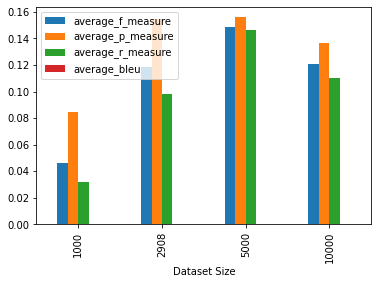

In [10]:


import matplotlib.pyplot as plot
from matplotlib.ticker import ScalarFormatter
#,figsize=(10,15)
table.plot.bar(x="Dataset Size")
plot.show(block=True);

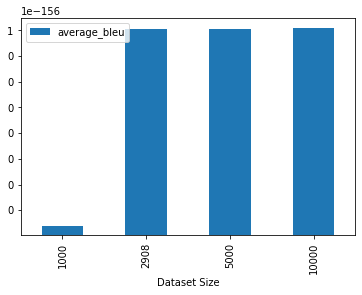

In [11]:
table.plot.bar(x="Dataset Size",y="average_bleu")
plot.yscale("log")
plot.gca().yaxis.set_major_formatter(ScalarFormatter())

plot.show(block=True);